In [5]:
import scipy
from scipy import stats
import pickle 
from sklearn.neighbors import KernelDensity

import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import math 
import collections
from pycocotools.coco import COCO
import requests
import plotly.express as px
import plotly.graph_objects as go
from os import listdir
from os.path import isfile, join
import base64
import itertools
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
sns.set(style='whitegrid', font_scale=1.6, font='Georgia', context='paper')

from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import operator
import plotly.figure_factory as ff
import scipy
import pickle 
from sklearn.neighbors import KernelDensity
from tqdm import tqdm
from collections import OrderedDict
from random import sample


/tmp/ipykernel_3268/3201064205.py:24: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


# Vanilla Stratified Beta Sampling

In [2]:
'''
* Traditional stratified beta sampling, given a beta distribution, 
    generate how much to sample from each bucket based on the cdf
* This does not ensure we are sampling up to the training budget 
'''

def stratified_beta_multilabel(df, alpha, beta, model, training_budget, dataset='animals'):
    #df = df.sample(frac=0.5, replace=False, random_state=1)
    targets = df['Target'].tolist()
    targets = [i[0] for i in targets]
    df['Target'] = targets
    orig_df = df.copy()
    all_ids = df['question_id'].to_list()

    #unique_targets = df['Target'].unique()
    targets_list = np.array(df['Target'].tolist())
    question_ids = np.array(df['question_id'].to_list())
    #confidence = np.array(df['confidence'].tolist())
    variability = np.array(df['variability'].tolist())


    targets_multilabel =[] # unique targets in vqa dataset 
    for i in targets_list:
        target_list = [x.strip() for x in i.split(',')]
        targets_multilabel.extend(target_list)
    unique_targets = set(targets_multilabel)

    df_variability = pd.DataFrame({'variability':variability, 'question_id':question_ids})
    bins = pd.cut(variability, bins=np.linspace(0, 0.5, 6), right=True, retbins=True)
    df_variability['bins'] = bins[0]
    
    beta_distribution = scipy.stats.beta(alpha, beta)
    sampling_percentages = [beta_distribution.cdf(0.2), beta_distribution.cdf(0.4)-beta_distribution.cdf(0.2), beta_distribution.cdf(0.6)-beta_distribution.cdf(0.4), beta_distribution.cdf(0.8)-beta_distribution.cdf(0.6), beta_distribution.cdf(1) - beta_distribution.cdf(0.8)]
    #sampling_percentages = [beta_distribution.cdf(0.25), beta_distribution.cdf(0.5)-beta_distribution.cdf(0.25), beta_distribution.cdf(0.75)-beta_distribution.cdf(0.5), beta_distribution.cdf(1)-beta_distribution.cdf(0.75)]
    unique_bins = df_variability['bins'].unique().tolist()
    print(unique_bins)

    first_bin = df_variability.loc[df_variability['bins'] == unique_bins[2]]
    second_bin = df_variability.loc[df_variability['bins'] == unique_bins[0]]
    third_bin = df_variability.loc[df_variability['bins'] == unique_bins[1]]
    fourth_bin = df_variability.loc[df_variability['bins'] == unique_bins[3]]
    fifth_bin = df_variability.loc[df_variability['bins'] == unique_bins[4]]

    all_bins = [first_bin, second_bin, third_bin, fourth_bin, fifth_bin]
    final_sample = []
    final_sample_ids = []
    for idx, sampling_percentage in enumerate(sampling_percentages):
        sampled_points = all_bins[idx].sample(frac=sampling_percentage, replace=False)
        final_sample.extend(sampled_points['variability'].tolist())
        final_sample_ids.extend(sampled_points['question_id'].tolist())
    sns.histplot(final_sample, kde=True)
    total_samples = round((training_budget*0.01) * len(all_ids))
    print("Total samples: ", total_samples)
    print("sample size: ", len(set(final_sample)))


    save_path = '../../../src/dataset_selection/sampling/samples/'+model+'/'+dataset+'/beta/var_stratified/seed_'+str(965)+'/alpha_'+str(alpha)+'_beta_'+str(beta)+'_budget_'+str(training_budget)+'.pkl'
    with open(save_path, 'wb') as f:
        pickle.dump(list(set(final_sample_ids)), f)

    unique_targets_sample = orig_df[orig_df['question_id'].isin(final_sample_ids)]
    sampled_targets_unique =[] # unique targets in vqa dataset 
    targets_list_sampled = np.array(unique_targets_sample['Target'].tolist())
    for i in targets_list_sampled:
        target_list = [x.strip() for x in i.split(',')]
        sampled_targets_unique.extend(target_list)
    unique_targets_sampled = set(sampled_targets_unique)

    # sampled_targets_unique = [] # unique targets in sampled data
    # sampled_targets = set(unique_targets_sample['Target'].unique())
    # for sample in sampled_targets:
    #     target_list = [x.strip() for x in sample.split(',')]
    #     sampled_targets_unique.extend(target_list)
    # sampled_targets_unique = set(sampled_targets_unique)
    targets_excluded = unique_targets - unique_targets_sampled
    print("TARGETS excluded: ", len(targets_excluded))

    print("unique targets max variability per class: ", len(set(unique_targets_sampled)))
    print('samples - max variability per class: ', len(set(final_sample)))
    print('all_samples - max variability per class: ', len(all_ids))

[Interval(0.1, 0.2, closed='right'), Interval(0.2, 0.3, closed='right'), Interval(0.0, 0.1, closed='right'), Interval(0.3, 0.4, closed='right'), Interval(0.4, 0.5, closed='right')]
Total samples:  198205
sample size:  154715
TARGETS excluded:  4
unique targets max variability per class:  3124
samples - max variability per class:  154715
all_samples - max variability per class:  619390


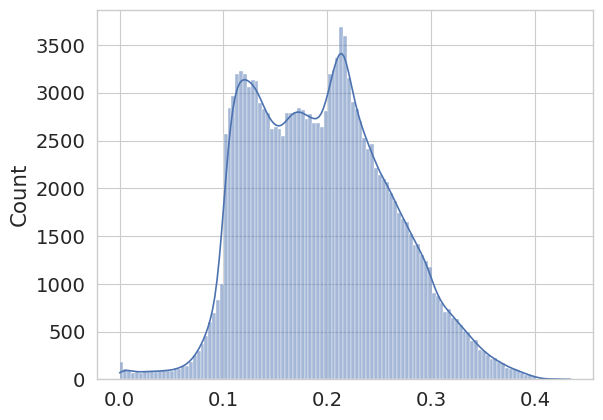

In [6]:

sampling_dataset = 'multilabel_full'
sampling_model = 'LXR111'


base_path = '../../../snap/vqa/lxr111_multilabel_full_run_3/'
df = pd.read_pickle(base_path+"datamap_metrics.pkl")

stratified_beta_multilabel(df, 2, 2, sampling_model, 32, dataset=sampling_dataset)

# Stratified to reach budget

In [2]:
'''
* Generate sampling percentages from beta cdf similar to vanilla stratified beta sampling, 
but determine the number of examples to sample by taking that percentage of the budget
* If there are not enough samples in that bucket, just take all the samples from that bucket 
* This still does not ensure we reach our training budget 
'''
def stratified_beta_multilabel_mod(df, alpha, beta, model, training_budget, dataset='animals'):
    #df = df.sample(frac=0.5, replace=False, random_state=1)
    targets = df['Target'].tolist()
    targets = [i[0] for i in targets]
    df['Target'] = targets
    orig_df = df.copy()
    all_ids = df['question_id'].to_list()
    total_samples = round((training_budget*0.01) * len(all_ids))

    # sampled_question_ids = []
    # sampled_variabilities = []
    # sampled_confidence = []
    # sampled_correctness = []
    # sampled_targets = []

    #unique_targets = df['Target'].unique()
    targets_list = np.array(df['Target'].tolist())
    question_ids = np.array(df['question_id'].to_list())
    #confidence = np.array(df['confidence'].tolist())
    variability = np.array(df['variability'].tolist())


    targets_multilabel =[] # unique targets in vqa dataset 
    for i in targets_list:
        target_list = [x.strip() for x in i.split(',')]
        targets_multilabel.extend(target_list)
    unique_targets = set(targets_multilabel)

    df_variability = pd.DataFrame({'variability':variability, 'question_id':question_ids})
    bins = pd.cut(variability, bins=np.linspace(0, 0.5, 6), right=True, retbins=True)
    df_variability['bins'] = bins[0]
    
    beta_distribution = scipy.stats.beta(alpha, beta)
    sampling_percentages = [beta_distribution.cdf(0.2), beta_distribution.cdf(0.4)-beta_distribution.cdf(0.2), beta_distribution.cdf(0.6)-beta_distribution.cdf(0.4), beta_distribution.cdf(0.8)-beta_distribution.cdf(0.6), beta_distribution.cdf(1) - beta_distribution.cdf(0.8)]
    #sampling_percentages = [beta_distribution.cdf(0.25), beta_distribution.cdf(0.5)-beta_distribution.cdf(0.25), beta_distribution.cdf(0.75)-beta_distribution.cdf(0.5), beta_distribution.cdf(1)-beta_distribution.cdf(0.75)]
    unique_bins = df_variability['bins'].unique().tolist()
    print(unique_bins)

    first_bin = df_variability.loc[df_variability['bins'] == unique_bins[2]]
    second_bin = df_variability.loc[df_variability['bins'] == unique_bins[0]]
    third_bin = df_variability.loc[df_variability['bins'] == unique_bins[1]]
    fourth_bin = df_variability.loc[df_variability['bins'] == unique_bins[3]]
    fifth_bin = df_variability.loc[df_variability['bins'] == unique_bins[4]]
    print(fifth_bin)

    all_bins = [first_bin, second_bin, third_bin, fourth_bin, fifth_bin]
    final_sample = []
    final_sample_ids = []
    for idx, sampling_percentage in enumerate(sampling_percentages):
        num_samples = round(sampling_percentage * total_samples)
        if num_samples > len(all_bins[idx]):
            print('idx: ', idx)
            print(num_samples)
            print(len(all_bins[idx]))
            num_samples = len(all_bins[idx])
        
        sampled_points = all_bins[idx].sample(n=num_samples, replace=False)
        final_sample.extend(sampled_points['variability'].tolist())
        final_sample_ids.extend(sampled_points['question_id'].tolist())
    sns.histplot(final_sample, kde=True)
    print("Total samples: ", total_samples)
    print("sample size: ", len(set(final_sample)))


    save_path = '../../../src/dataset_selection/sampling/samples/'+model+'/'+dataset+'/beta/var_stratified/seed_'+str(965)+'/alpha_'+str(alpha)+'_beta_'+str(beta)+'_budget_'+str(training_budget)+'mod.pkl'
    with open(save_path, 'wb') as f:
        pickle.dump(list(set(final_sample_ids)), f)

    unique_targets_sample = orig_df[orig_df['question_id'].isin(final_sample_ids)]
    sampled_targets_unique =[] # unique targets in vqa dataset 
    targets_list_sampled = np.array(unique_targets_sample['Target'].tolist())
    for i in targets_list_sampled:
        target_list = [x.strip() for x in i.split(',')]
        sampled_targets_unique.extend(target_list)
    unique_targets_sampled = set(sampled_targets_unique)

    # sampled_targets_unique = [] # unique targets in sampled data
    # sampled_targets = set(unique_targets_sample['Target'].unique())
    # for sample in sampled_targets:
    #     target_list = [x.strip() for x in sample.split(',')]
    #     sampled_targets_unique.extend(target_list)
    # sampled_targets_unique = set(sampled_targets_unique)
    targets_excluded = unique_targets - unique_targets_sampled
    print("TARGETS excluded: ", len(targets_excluded))

    print("unique targets max variability per class: ", len(set(unique_targets_sampled)))
    print('samples - max variability per class: ', len(set(final_sample)))
    print('all_samples - max variability per class: ', len(all_ids))

[Interval(0.1, 0.2, closed='right'), Interval(0.2, 0.3, closed='right'), Interval(0.0, 0.1, closed='right'), Interval(0.3, 0.4, closed='right'), Interval(0.4, 0.5, closed='right')]
idx:  4
37163
443
Total samples:  185817
sample size:  149095
TARGETS excluded:  3
unique targets max variability per class:  3125
samples - max variability per class:  149095
all_samples - max variability per class:  619390


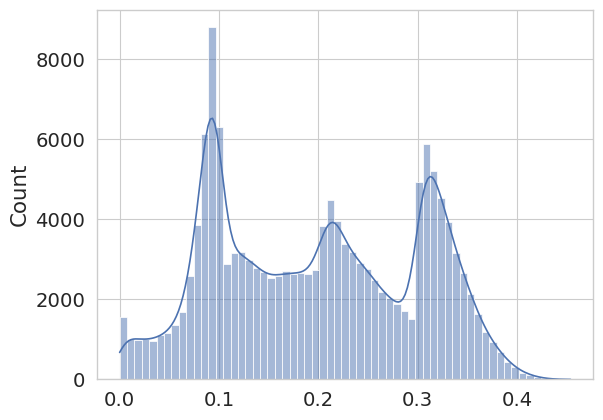

In [12]:

sampling_dataset = 'multilabel_full'
sampling_model = 'LXR111'

base_path = '../../../snap/vqa/lxr111_multilabel_full_run_3/'
df = pd.read_pickle(base_path+"datamap_metrics.pkl")

stratified_beta_multilabel_mod(df, 1, 1, sampling_model, 30, dataset=sampling_dataset) 

# Print bins

In [15]:
'''
* Generate sampling percentages from beta cdf similar to vanilla stratified beta sampling, 
but determine the number of examples to sample by taking that percentage of the budget
* If there are not enough samples in that bucket, just take all the samples from that bucket 
* This still does not ensure we reach our training budget 
'''
def print_bins(df, model, dataset='animals'):
    #df = df.sample(frac=0.5, replace=False, random_state=1)
    targets = df['Target'].tolist()
    targets = [i[0] for i in targets]
    df['Target'] = targets
    orig_df = df.copy()
    all_ids = df['question_id'].to_list()
    #total_samples = round((training_budget*0.01) * len(all_ids))

    targets_list = np.array(df['Target'].tolist())
    question_ids = np.array(df['question_id'].to_list())
    variability = np.array(df['variability'].tolist())


    targets_multilabel =[] # unique targets in vqa dataset 
    for i in targets_list:
        target_list = [x.strip() for x in i.split(',')]
        targets_multilabel.extend(target_list)
    unique_targets = set(targets_multilabel)

    #df_variability = pd.DataFrame({'variability':variability, 'question_id':question_ids})
    bins = pd.cut(variability, bins=np.linspace(0, 0.5, 6), right=True, retbins=True)
    df['bins'] = bins[0]
    
    unique_bins = df['bins'].unique().tolist()
    print(unique_bins)

    first_bin = df.loc[df['bins'] == unique_bins[2]]
    second_bin = df.loc[df['bins'] == unique_bins[0]]
    third_bin = df.loc[df['bins'] == unique_bins[1]]
    fourth_bin = df.loc[df['bins'] == unique_bins[3]]
    fifth_bin = df.loc[df['bins'] == unique_bins[4]]
    fifth_bin.to_pickle('../../../src/dataset_selection/sampling/last_bin.pkl')  
    #print(fifth_bin) 

In [16]:
sampling_dataset = 'multilabel_full'
sampling_model = 'LXR111'

base_path = '../../../snap/vqa/lxr111_multilabel_full_run_3/'
df = pd.read_pickle(base_path+"datamap_metrics.pkl")

print_bins(df, sampling_model, dataset=sampling_dataset) 
unpickled_df = pd.read_pickle('../../../src/dataset_selection/sampling/last_bin.pkl')  

[Interval(0.1, 0.2, closed='right'), Interval(0.2, 0.3, closed='right'), Interval(0.0, 0.1, closed='right'), Interval(0.3, 0.4, closed='right'), Interval(0.4, 0.5, closed='right')]


# random-near-mode-variability

In [6]:
'''
* Just take the mode of the histogram of variability distributions and sample 30% from there

* With the way our data is distributed, this ensures we sample up to the training budget 
'''
def stratified_beta_multilabel_middle(df, lower, upper, model, training_budget, dataset='animals'):
    #df = df.sample(frac=0.5, replace=False, random_state=1)
    targets = df['Target'].tolist()
    targets = [i[0] for i in targets]
    df['Target'] = targets
    orig_df = df.copy()
    all_ids = df['question_id'].to_list()
    total_samples = round((training_budget*0.01) * len(all_ids))

    targets_list = np.array(df['Target'].tolist())
    question_ids = np.array(df['question_id'].to_list())
    variability = np.array(df['variability'].tolist())


    targets_multilabel =[] # unique targets in vqa dataset 
    for i in targets_list:
        target_list = [x.strip() for x in i.split(',')]
        targets_multilabel.extend(target_list)
    unique_targets = set(targets_multilabel)

    df_variability = pd.DataFrame({'variability':variability, 'question_id':question_ids})
    bins = pd.cut(variability, bins=np.linspace(0, 0.5, 6), right=True, retbins=True)
    df_variability['bins'] = bins[0]
    
    #beta_distribution = scipy.stats.beta(alpha, beta)
    #sampling_percentages = [beta_distribution.cdf(0.2), beta_distribution.cdf(0.4)-beta_distribution.cdf(0.2), beta_distribution.cdf(0.6)-beta_distribution.cdf(0.4), beta_distribution.cdf(0.8)-beta_distribution.cdf(0.6), beta_distribution.cdf(1) - beta_distribution.cdf(0.8)]
    #sampling_percentages = [beta_distribution.cdf(0.25), beta_distribution.cdf(0.5)-beta_distribution.cdf(0.25), beta_distribution.cdf(0.75)-beta_distribution.cdf(0.5), beta_distribution.cdf(1)-beta_distribution.cdf(0.75)]
    unique_bins = df_variability['bins'].unique().tolist()
    print(unique_bins)

    first_bin = df_variability.loc[df_variability['bins'] == unique_bins[2]]
    second_bin = df_variability.loc[df_variability['bins'] == unique_bins[0]]
    third_bin = df_variability.loc[df_variability['bins'] == unique_bins[1]]
    fourth_bin = df_variability.loc[df_variability['bins'] == unique_bins[3]]
    fifth_bin = df_variability.loc[df_variability['bins'] == unique_bins[4]]
    all_bins = [first_bin, second_bin, third_bin, fourth_bin, fifth_bin]

    bins_range= [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    idx_lower = bins_range.index(lower)
    idx_upper = bins_range.index(upper) 

    frames = []
    if idx_lower == (idx_upper - 1):
        # add a single bin range 
        frames.append(all_bins[idx_lower])
    else:
        if idx_lower == (idx_upper + 1):
            # only two consecutive bins
            frames.append(all_bins[idx_lower])
            frames.append(all_bins[idx_upper - 1])
        else:
            # concatenate 
            for i in range(idx_lower, idx_upper):
                frames.append(all_bins[i])
        
    result = pd.concat(frames)

    final_sample_df = result.sample(n=total_samples, replace=False, random_state=965)
    # final_sample_df = result.sample(n=total_samples, replace=False, random_state=965, weights='variability')
    final_sample = final_sample_df['variability'].tolist()
    final_sample_ids = final_sample_df['question_id'].tolist()


    sns.histplot(final_sample, kde=True)
    print("Total samples: ", total_samples)
    print("sample size: ", len(set(final_sample)))


    save_path = '../../../src/dataset_selection/sampling/samples/'+model+'/'+dataset+'/random_near_mode_variability/seed_'+str(965)+'/middle_buckets_' + str(lower) + '_' + str(upper) + '.pkl'
    with open(save_path, 'wb') as f:
        pickle.dump(list(set(final_sample_ids)), f)

    unique_targets_sample = orig_df[orig_df['question_id'].isin(final_sample_ids)]
    sampled_targets_unique =[] # unique targets in vqa dataset 
    targets_list_sampled = np.array(unique_targets_sample['Target'].tolist())
    for i in targets_list_sampled:
        target_list = [x.strip() for x in i.split(',')]
        sampled_targets_unique.extend(target_list)
    unique_targets_sampled = set(sampled_targets_unique)

    targets_excluded = unique_targets - unique_targets_sampled
    print(targets_excluded)
    print("TARGETS excluded: ", len(targets_excluded))

    print("unique targets max variability per class: ", len(set(unique_targets_sampled)))
    print('samples - max variability per class: ', len(set(final_sample)))
    print('all_samples - max variability per class: ', len(all_ids))

[Interval(0.1, 0.2, closed='right'), Interval(0.2, 0.3, closed='right'), Interval(0.0, 0.1, closed='right'), Interval(0.3, 0.4, closed='right'), Interval(0.4, 0.5, closed='right')]
Total samples:  185817
sample size:  185817
{'eiffel tower', 'telling time', 'ring finger', 'in cabbage town', 'on rock', 'sesame seeds', 'diet coke', 'star alliance', 'htc', 'shorter', '100 year party ct', 'polar bears', 'dog food', 'hammock', 'thomas', '1 4', 'sas', '870', 'blood', 'tents', 'parmesan cheese', 'korean air', 'pm', 'jetblue', 'petting horse', 'dairy queen', 'space needle', 'baseball uniform', 'skyscrapers', 'give way', 'national express', 'easyjet', 'hsbc', 'wreath', 'gazebo', '5:18', 'qatar', 'opponent', 'csx', 'westin', 'tires', 'different teams', 'throw ball', 'corona', 'westjet', 'scrambled', 'us airways express', 'tattoos', 'dreadlocks', '1 world', 'maple leaf', 'babies', 'cosmo', 'pacifier', 'virgin atlantic', 'tinkerbell', 'wall st', 'washington monument', 'refrigerators'}
TARGETS excl

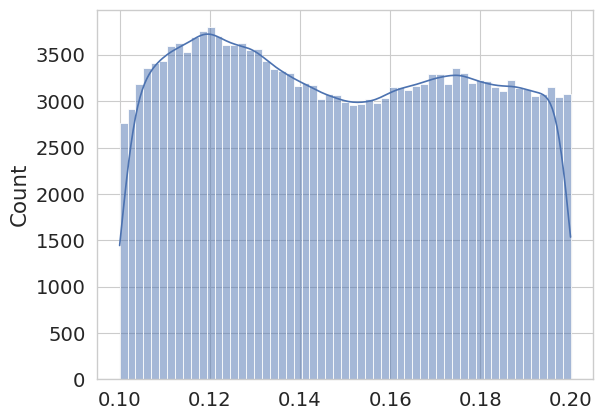

In [8]:

sampling_dataset = 'multilabel_full'
sampling_model = 'LXR111'


base_path = '../../../snap/vqa/lxr111_multilabel_full_run_3/'
df = pd.read_pickle(base_path+"datamap_metrics.pkl")

stratified_beta_multilabel_middle(df, 0.1, 0.2, sampling_model, 30, dataset=sampling_dataset)

# Random-near-mode -confidence 

In [11]:
'''
* Just take the mode of the histogram of variability distributions and sample 30% from there

* With the way our data is distributed, this ensures we sample up to the training budget 
'''
def random_near_mode_confidence(df, lower, upper, model, training_budget, dataset='animals'):
    #df = df.sample(frac=0.5, replace=False, random_state=1)
    targets = df['Target'].tolist()
    targets = [i[0] for i in targets]
    df['Target'] = targets
    orig_df = df.copy()
    all_ids = df['question_id'].to_list()
    total_samples = round((training_budget*0.01) * len(all_ids))
    print("TOTAL SAMPLES: ", total_samples)

    targets_list = np.array(df['Target'].tolist())
    question_ids = np.array(df['question_id'].to_list())
    variability = np.array(df['variability'].tolist())
    confidence = np.array(df['confidence'].tolist())



    targets_multilabel =[] # unique targets in vqa dataset 
    for i in targets_list:
        target_list = [x.strip() for x in i.split(',')]
        targets_multilabel.extend(target_list)
    unique_targets = set(targets_multilabel)

    df_confidence = pd.DataFrame({'confidence':confidence, 'question_id':question_ids})
    bins = pd.cut(confidence, bins=np.linspace(0, 1.0, 6), right=True, retbins=True)
    df_confidence['bins'] = bins[0]
    
    #beta_distribution = scipy.stats.beta(alpha, beta)
    #sampling_percentages = [beta_distribution.cdf(0.2), beta_distribution.cdf(0.4)-beta_distribution.cdf(0.2), beta_distribution.cdf(0.6)-beta_distribution.cdf(0.4), beta_distribution.cdf(0.8)-beta_distribution.cdf(0.6), beta_distribution.cdf(1) - beta_distribution.cdf(0.8)]
    #sampling_percentages = [beta_distribution.cdf(0.25), beta_distribution.cdf(0.5)-beta_distribution.cdf(0.25), beta_distribution.cdf(0.75)-beta_distribution.cdf(0.5), beta_distribution.cdf(1)-beta_distribution.cdf(0.75)]
    unique_bins = df_confidence['bins'].unique().tolist()
    print(unique_bins)

    first_bin = df_confidence.loc[df_confidence['bins'] == unique_bins[0]]
    second_bin = df_confidence.loc[df_confidence['bins'] == unique_bins[1]]
    third_bin = df_confidence.loc[df_confidence['bins'] == unique_bins[2]]
    fourth_bin = df_confidence.loc[df_confidence['bins'] == unique_bins[4]]
    fifth_bin = df_confidence.loc[df_confidence['bins'] == unique_bins[3]]
    all_bins = [first_bin, second_bin, third_bin, fourth_bin, fifth_bin]

    bins_range= [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    idx_lower = bins_range.index(lower)
    idx_upper = bins_range.index(upper) 

    frames = []
    if idx_lower == (idx_upper - 1):
        # add a single bin range 
        frames.append(all_bins[idx_lower])
    else:
        if idx_lower == (idx_upper + 1):
            # only two consecutive bins
            frames.append(all_bins[idx_lower])
            frames.append(all_bins[idx_upper - 1])
        else:
            # concatenate 
            for i in range(idx_lower, idx_upper):
                frames.append(all_bins[i])
        
    result = pd.concat(frames)

    final_sample_df = result.sample(n=total_samples, replace=False, random_state=965)
    #final_sample_df = result.sample(n=total_samples, replace=False, random_state=965, weights='confidence')
    final_sample = final_sample_df['confidence'].tolist()
    final_sample_ids = final_sample_df['question_id'].tolist()


    sns.histplot(final_sample, kde=True)
    print("Total samples: ", total_samples)
    print("before: ", len(final_sample))
    print("sample size: ", len(set(final_sample)))


    save_path = '../../../src/dataset_selection/sampling/samples/'+model+'/'+dataset+'/random_near_mode_confidence/seed_'+str(965)+'/middle_buckets_' + str(lower) + '_' + str(upper) + '.pkl'
    with open(save_path, 'wb') as f:
        pickle.dump(list(set(final_sample_ids)), f)

    unique_targets_sample = orig_df[orig_df['question_id'].isin(final_sample_ids)]
    sampled_targets_unique =[] # unique targets in vqa dataset 
    targets_list_sampled = np.array(unique_targets_sample['Target'].tolist())
    for i in targets_list_sampled:
        target_list = [x.strip() for x in i.split(',')]
        sampled_targets_unique.extend(target_list)
    unique_targets_sampled = set(sampled_targets_unique)

    targets_excluded = unique_targets - unique_targets_sampled
    print(targets_excluded)
    print("TARGETS excluded: ", len(targets_excluded))

    print("unique targets: ", len(set(unique_targets_sampled)))
    print('samples: ', len(set(final_sample)))
    print('all_samples: ', len(all_ids))

TOTAL SAMPLES:  185817
[Interval(0.0, 0.2, closed='right'), Interval(0.2, 0.4, closed='right'), Interval(0.4, 0.6, closed='right'), Interval(0.8, 1.0, closed='right'), Interval(0.6, 0.8, closed='right')]
Total samples:  185817
before:  185817
sample size:  185811
{'7:25', '5 star', '1 4'}
TARGETS excluded:  3
unique targets:  3125
samples:  185811
all_samples:  619390


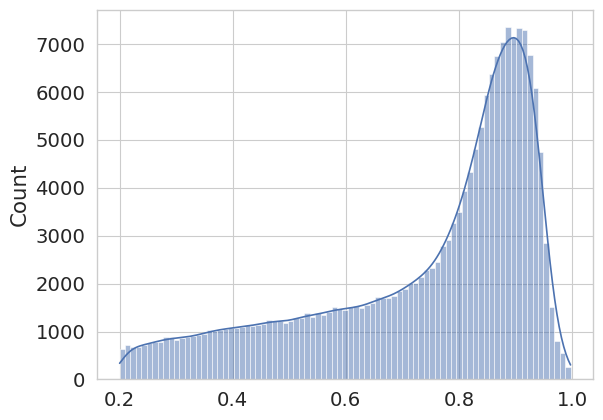

In [15]:

sampling_dataset = 'multilabel_full'
sampling_model = 'LXR111'


base_path = '../../../snap/vqa/lxr111_multilabel_full_run_3/'
df = pd.read_pickle(base_path+"datamap_metrics.pkl")

random_near_mode_confidence(df, 0.2, 1.0, sampling_model, 30, dataset=sampling_dataset)

# Normal-near-mode-variability

In [16]:
'''
* Just take the mode of the histogram of variability distributions and sample 30% from there

* With the way our data is distributed, this ensures we sample up to the training budget 
'''

import scipy
def normal_near_mode_variability(df, lower, upper, model, training_budget, dataset='animals'):
    #df = df.sample(frac=0.5, replace=False, random_state=1)
    targets = df['Target'].tolist()
    targets = [i[0] for i in targets]
    df['Target'] = targets
    orig_df = df.copy()
    all_ids = df['question_id'].to_list()
    total_samples = round((training_budget*0.01) * len(all_ids))

    targets_list = np.array(df['Target'].tolist())
    question_ids = np.array(df['question_id'].to_list())
    variability = np.array(df['variability'].tolist())


    targets_multilabel =[] # unique targets in vqa dataset 
    for i in targets_list:
        target_list = [x.strip() for x in i.split(',')]
        targets_multilabel.extend(target_list)
    unique_targets = set(targets_multilabel)

    df_variability = pd.DataFrame({'variability':variability, 'question_id':question_ids})
    bins = pd.cut(variability, bins=np.linspace(0, 0.5, 6), right=True, retbins=True)
    df_variability['bins'] = bins[0]
    
    #beta_distribution = scipy.stats.beta(alpha, beta)
    #sampling_percentages = [beta_distribution.cdf(0.2), beta_distribution.cdf(0.4)-beta_distribution.cdf(0.2), beta_distribution.cdf(0.6)-beta_distribution.cdf(0.4), beta_distribution.cdf(0.8)-beta_distribution.cdf(0.6), beta_distribution.cdf(1) - beta_distribution.cdf(0.8)]
    #sampling_percentages = [beta_distribution.cdf(0.25), beta_distribution.cdf(0.5)-beta_distribution.cdf(0.25), beta_distribution.cdf(0.75)-beta_distribution.cdf(0.5), beta_distribution.cdf(1)-beta_distribution.cdf(0.75)]
    unique_bins = df_variability['bins'].unique().tolist()
    print(unique_bins)

    first_bin = df_variability.loc[df_variability['bins'] == unique_bins[2]]
    second_bin = df_variability.loc[df_variability['bins'] == unique_bins[0]]
    third_bin = df_variability.loc[df_variability['bins'] == unique_bins[1]]
    fourth_bin = df_variability.loc[df_variability['bins'] == unique_bins[3]]
    fifth_bin = df_variability.loc[df_variability['bins'] == unique_bins[4]]
    all_bins = [first_bin, second_bin, third_bin, fourth_bin, fifth_bin]

    bins_range= [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    idx_lower = bins_range.index(lower)
    idx_upper = bins_range.index(upper) 

    frames = []
    if idx_lower == (idx_upper - 1):
        # add a single bin range 
        frames.append(all_bins[idx_lower])
    else:
        if idx_lower == (idx_upper + 1):
            # only two consecutive bins
            frames.append(all_bins[idx_lower])
            frames.append(all_bins[idx_upper - 1])
        else:
            # concatenate 
            for i in range(idx_lower, idx_upper):
                frames.append(all_bins[i])
        
    result = pd.concat(frames)
    variabilities_clipped = np.array(result['variability'].tolist()) * 2
    question_ids_clipped = np.array(result['question_id'].tolist())


    normal_distribution = scipy.stats.norm()
    p_vals = normal_distribution.pdf(variabilities_clipped)
    p_vals /= p_vals.sum()
    idx = np.random.choice(np.arange(len(variabilities_clipped)), total_samples, replace=False, p=p_vals)
    final_sample = variabilities_clipped[idx]
    final_sample_ids = question_ids_clipped[idx]

    
    # final_sample_df = result.sample(n=total_samples, replace=False, random_state=965) # normal sample from this region
    # # final_sample_df = result.sample(n=total_samples, replace=False, random_state=965, weights='variability')
    # final_sample = final_sample_df['variability'].tolist()
    # final_sample_ids = final_sample_df['question_id'].tolist()


    sns.histplot(final_sample/2, kde=True)
    print("Total samples: ", total_samples)
    print("sample size: ", len(set(final_sample)))


    save_path = '../../../src/dataset_selection/sampling/samples/'+model+'/'+dataset+'/normal_near_mode_variability/seed_'+str(965)+'/middle_buckets_' + str(lower) + '_' + str(upper) + '.pkl'
    with open(save_path, 'wb') as f:
        pickle.dump(list(set(final_sample_ids)), f)

    unique_targets_sample = orig_df[orig_df['question_id'].isin(final_sample_ids)]
    sampled_targets_unique =[] # unique targets in vqa dataset 
    targets_list_sampled = np.array(unique_targets_sample['Target'].tolist())
    for i in targets_list_sampled:
        target_list = [x.strip() for x in i.split(',')]
        sampled_targets_unique.extend(target_list)
    unique_targets_sampled = set(sampled_targets_unique)

    targets_excluded = unique_targets - unique_targets_sampled
    print(targets_excluded)
    print("TARGETS excluded: ", len(targets_excluded))

    print("unique targets normal near mode variability: ", len(set(unique_targets_sampled)))
    print('samples - normal near mode variability: ', len(set(final_sample)))
    print('all_samples - normal near mode variability: ', len(all_ids))

[Interval(0.1, 0.2, closed='right'), Interval(0.2, 0.3, closed='right'), Interval(0.0, 0.1, closed='right'), Interval(0.3, 0.4, closed='right'), Interval(0.4, 0.5, closed='right')]
Total samples:  185817
sample size:  185817
{'1 4', 'htc', '100 year party ct'}
TARGETS excluded:  3
unique targets normal near mode variability:  3125
samples - normal near mode variability:  185817
all_samples - normal near mode variability:  619390


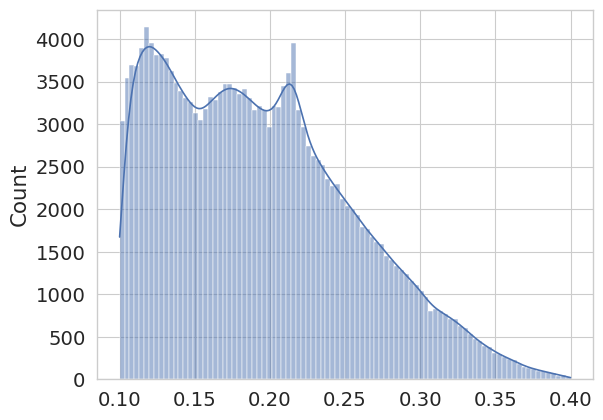

In [19]:
sampling_dataset = 'multilabel_full'
sampling_model = 'LXR111'


base_path = '../../../snap/vqa/lxr111_multilabel_full_run_3/'
df = pd.read_pickle(base_path+"datamap_metrics.pkl")

normal_near_mode_variability(df, 0.1, 0.4, sampling_model, 30, dataset=sampling_dataset)

# Beta-Conf-Pvals

In [22]:
def beta_conf_pvals(df, alpha, beta, model, training_budget, dataset='animals'):
    #df = df.sample(frac=0.5, replace=False, random_state=1)
    targets = df['Target'].tolist()
    targets = [i[0] for i in targets]
    df['Target'] = targets
    orig_df = df.copy()
    all_ids = df['question_id'].to_list()
    total_samples = round((training_budget*0.01) * len(all_ids))

    targets_list = np.array(df['Target'].tolist())
    question_ids = np.array(df['question_id'].to_list())
    #variability = np.array(df['variability'].tolist()) * 2
    confidence = np.array(df['confidence'].tolist())



    targets_multilabel =[] # unique targets in vqa dataset 
    for i in targets_list:
        target_list = [x.strip() for x in i.split(',')]
        targets_multilabel.extend(target_list)
    unique_targets = set(targets_multilabel)


    beta_distribution = scipy.stats.beta(alpha, beta)
    p_vals = beta_distribution.pdf(confidence)
    p_vals /= p_vals.sum()
    idx = np.random.choice(np.arange(len(confidence)), total_samples, replace=False, p=p_vals)
    final_sample = confidence[idx]
    final_sample_ids = question_ids[idx]


    sns.histplot(final_sample, kde=True)
    print("Total samples: ", total_samples)
    print("sample size: ", len(set(final_sample)))

    save_path = '../../../src/dataset_selection/sampling/samples/'+model+'/'+dataset+'/beta/beta_pvals_conf/seed_'+str(965)+'/alpha_'+str(alpha)+'_beta_'+str(beta)+'_budget_'+str(training_budget)+'.pkl'

    with open(save_path, 'wb') as f:
        pickle.dump(list(set(final_sample_ids)), f)

    unique_targets_sample = orig_df[orig_df['question_id'].isin(final_sample_ids)]
    sampled_targets_unique =[] # unique targets in vqa dataset 
    targets_list_sampled = np.array(unique_targets_sample['Target'].tolist())
    for i in targets_list_sampled:
        target_list = [x.strip() for x in i.split(',')]
        sampled_targets_unique.extend(target_list)
    unique_targets_sampled = set(sampled_targets_unique)

    targets_excluded = unique_targets - unique_targets_sampled
    print(targets_excluded)

    print("TARGETS excluded: ", len(targets_excluded))
    print("unique targets beta pvals: ", len(set(unique_targets_sampled)))
    print('samples - beta pvals: ', len(set(final_sample)))
    print('all_samples - beta pvals: ', len(all_ids))

Total samples:  185817
sample size:  185816
set()
TARGETS excluded:  0
unique targets beta pvals:  3128
samples - beta pvals:  185816
all_samples - beta pvals:  619390


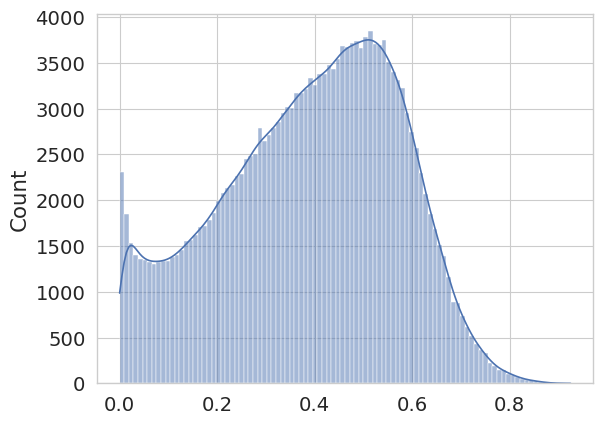

In [30]:
sampling_dataset = 'multilabel_full'
sampling_model = 'LXR111'

base_path = '../../../snap/vqa/lxr111_multilabel_full_run_3/'
df = pd.read_pickle(base_path+"datamap_metrics.pkl")

beta_conf_pvals(df, 2, 8, sampling_model, 30, dataset=sampling_dataset)

# Stratified variability/confidence priors

In [39]:
# split variability into 3 buckets
# in first bucket, only include samples from high confidence region, 
    # so our buckets now become the confidence buckets, and we generate sampling percentages from cdf of beta-(8,2)
# in second bucket, draw a beta distribution beta-(2,1) using confidence buckets
# in third bucket, sample randomly to reach training budget 

def stratified_beta_multilabel_var_conf(df, model, training_budget, dataset='animals'):
    #df = df.sample(frac=0.5, replace=False, random_state=1)
    targets = df['Target'].tolist()
    targets = [i[0] for i in targets]
    df['Target'] = targets
    orig_df = df.copy()
    all_ids = df['question_id'].to_list()
    total_samples = round((training_budget*0.01) * len(all_ids))

    #unique_targets = df['Target'].unique()
    targets_list = np.array(df['Target'].tolist())
    question_ids = np.array(df['question_id'].to_list())
    confidence = np.array(df['confidence'].tolist())
    variability = np.array(df['variability'].tolist())


    targets_multilabel =[] # unique targets in vqa dataset 
    for i in targets_list:
        target_list = [x.strip() for x in i.split(',')]
        targets_multilabel.extend(target_list)
    unique_targets = set(targets_multilabel)

    df_variability = pd.DataFrame({'variability':variability, 'confidence':confidence, 'question_id':question_ids})
    bins = pd.cut(variability, bins=np.linspace(0, 0.5, 4), right=True, retbins=True)
    bins_conf = pd.cut(confidence, bins=np.linspace(0, 1.0, 6), right=True, retbins=True)
    df_variability['bins'] = bins[0]
    df_variability['bins_conf'] = bins_conf[0]
    
    # beta_distribution = scipy.stats.beta(alpha, beta)
    # sampling_percentages = [beta_distribution.cdf(0.2), beta_distribution.cdf(0.4)-beta_distribution.cdf(0.2), beta_distribution.cdf(0.6)-beta_distribution.cdf(0.4), beta_distribution.cdf(0.8)-beta_distribution.cdf(0.6), beta_distribution.cdf(1) - beta_distribution.cdf(0.8)]
    #sampling_percentages = [beta_distribution.cdf(0.25), beta_distribution.cdf(0.5)-beta_distribution.cdf(0.25), beta_distribution.cdf(0.75)-beta_distribution.cdf(0.5), beta_distribution.cdf(1)-beta_distribution.cdf(0.75)]
    unique_bins = df_variability['bins'].unique().tolist()
    print(unique_bins)
    unique_bins_conf = df_variability['bins_conf'].unique().tolist()
    print(unique_bins_conf)

    first_bin = df_variability.loc[df_variability['bins'] == unique_bins[0]]
    second_bin = df_variability.loc[df_variability['bins'] == unique_bins[1]]
    third_bin = df_variability.loc[df_variability['bins'] == unique_bins[2]]

    # bin proportions
    first_bin_percentage = len(first_bin) / len(variability)
    second_bin_percentage = len(second_bin) / len(variability)
    third_bin_percentage = len(third_bin) / len(variability)

    first_bin_target = round(first_bin_percentage * total_samples)
    second_bin_target = round(second_bin_percentage * total_samples)
    third_bin_target = round(third_bin_percentage * total_samples)

    print("first bin target: ", first_bin_target)
    print("second bin target: ", second_bin_target)
    print("third bin target: ", third_bin_target)
    

    all_bins = [first_bin, second_bin, third_bin]
    final_sample = []
    final_sample_ids = []
    final_sample_conf = []
    # in first bucket, only include samples from high confidence region, 
    # so our buckets now become the confidence buckets, and we generate sampling percentages from cdf of beta-(8,2)
    beta_distribution_first_bin = scipy.stats.beta(8, 2)

    first_bin_conf = first_bin.loc[first_bin['bins_conf'] == unique_bins_conf[0]]
    second_bin_conf = first_bin.loc[first_bin['bins_conf'] == unique_bins_conf[1]]
    third_bin_conf = first_bin.loc[first_bin['bins_conf'] == unique_bins_conf[2]]
    fourth_bin_conf = first_bin.loc[first_bin['bins_conf'] == unique_bins_conf[4]]
    fifth_bin_conf = first_bin.loc[first_bin['bins_conf'] == unique_bins_conf[3]]
    all_bins_conf = [first_bin_conf, second_bin_conf, third_bin_conf, fourth_bin_conf, fifth_bin_conf]

    # in first bucket, only add the highest confidence examples from first two confience buckets
    for confidence_bin in all_bins_conf[:-3]:
        final_sample.extend(confidence_bin['variability'].tolist())
        final_sample_conf.extend(confidence_bin['confidence'].tolist())
        final_sample_ids.extend(confidence_bin['question_id'].tolist())


    # the commented out code below is drawing a beta distribution over the first bucket but we might not need that ... first trying the extreme version of only taking the highest confidence examples
    
    # sampling_percentages_first_bin = [beta_distribution_first_bin.cdf(0.2), beta_distribution_first_bin.cdf(0.4)-beta_distribution_first_bin.cdf(0.2), beta_distribution_first_bin.cdf(0.6)-beta_distribution_first_bin.cdf(0.4), beta_distribution_first_bin.cdf(0.8)-beta_distribution_first_bin.cdf(0.6), beta_distribution_first_bin.cdf(1) - beta_distribution_first_bin.cdf(0.8)]
    # for idx, sampling_percentage in enumerate(sampling_percentages_first_bin):


    #     num_samples = round(sampling_percentage * first_bin_target)
    #     if num_samples > len(all_bins_conf[idx]):
    #         print("FIRST BIN")
    #         print('idx: ', idx)
    #         print('num samples required: ', num_samples)
    #         print('num samples in the bin: ', len(all_bins_conf[idx]))
    #         num_samples = len(all_bins_conf[idx])
    #     print("CONF BIN LENGTH: ", len(all_bins_conf[idx]))
        
    #     sampled_points = all_bins_conf[idx].sample(n=num_samples, replace=False)
    #     final_sample.extend(sampled_points['variability'].tolist())
    #     final_sample_ids.extend(sampled_points['question_id'].tolist())

    # if we didn't reach the first bin's target, just add that to the second bin's target so we're sampling more from the middle region 
    samples_left_first_bin = first_bin_target - len(final_sample)
    second_bin_target += samples_left_first_bin


    beta_distribution_second_bin = scipy.stats.beta(8,2)
    first_bin_conf = second_bin.loc[second_bin['bins_conf'] == unique_bins_conf[0]]
    second_bin_conf = second_bin.loc[second_bin['bins_conf'] == unique_bins_conf[1]]
    third_bin_conf = second_bin.loc[second_bin['bins_conf'] == unique_bins_conf[2]]
    fourth_bin_conf = second_bin.loc[second_bin['bins_conf'] == unique_bins_conf[4]]
    fifth_bin_conf = second_bin.loc[second_bin['bins_conf'] == unique_bins_conf[3]]
    all_bins_conf = [first_bin_conf, second_bin_conf, third_bin_conf, fourth_bin_conf, fifth_bin_conf]

    sampling_percentages_second_bin = [beta_distribution_second_bin.cdf(0.2), beta_distribution_second_bin.cdf(0.4)-beta_distribution_second_bin.cdf(0.2), beta_distribution_second_bin.cdf(0.6)-beta_distribution_second_bin.cdf(0.4), beta_distribution_second_bin.cdf(0.8)-beta_distribution_second_bin.cdf(0.6), beta_distribution_second_bin.cdf(1) - beta_distribution_second_bin.cdf(0.8)]
    for idx, sampling_percentage in enumerate(sampling_percentages_second_bin):

        num_samples = round(sampling_percentage * second_bin_target)
        if num_samples > len(all_bins_conf[idx]):
            print("SECOND BIN")
            print('idx: ', idx)
            print('num samples required: ', num_samples)
            print('num samples in the bin: ', len(all_bins_conf[idx]))
            num_samples = len(all_bins_conf[idx])

        sampled_points = all_bins_conf[idx].sample(n=num_samples, replace=False)

        final_sample_conf.extend(sampled_points['confidence'].tolist())
        final_sample.extend(sampled_points['variability'].tolist())
        final_sample_ids.extend(sampled_points['question_id'].tolist())

    samples_left = total_samples - len(final_sample)
    print("samples left: ", samples_left)
    if samples_left > 0:
        sampled_points = third_bin.sample(n=third_bin_target, replace=False)
        final_sample.extend(sampled_points['variability'].tolist())
        final_sample_ids.extend(sampled_points['question_id'].tolist())
        final_sample_conf.extend(sampled_points['confidence'].tolist())
        


    sns.histplot(final_sample, kde=True)
    
    print("Total samples: ", total_samples)
    print("sample size: ", len(set(final_sample)))


    save_path = '../../../src/dataset_selection/sampling/samples/'+model+'/'+dataset+'/beta/var_stratified/seed_'+str(965)+'/var_conf.pkl'
    with open(save_path, 'wb') as f:
        pickle.dump(list(set(final_sample_ids)), f)

    unique_targets_sample = orig_df[orig_df['question_id'].isin(final_sample_ids)]
    sampled_targets_unique =[] # unique targets in vqa dataset 
    targets_list_sampled = np.array(unique_targets_sample['Target'].tolist())
    for i in targets_list_sampled:
        target_list = [x.strip() for x in i.split(',')]
        sampled_targets_unique.extend(target_list)
    unique_targets_sampled = set(sampled_targets_unique)

    targets_excluded = unique_targets - unique_targets_sampled
    print("TARGETS excluded: ", len(targets_excluded))

    print("unique targets max variability per class: ", len(set(unique_targets_sampled)))
    print('samples - max variability per class: ', len(set(final_sample)))
    print('all_samples - max variability per class: ', len(all_ids))
    return final_sample_conf


[Interval(0.0, 0.167, closed='right'), Interval(0.167, 0.333, closed='right'), Interval(0.333, 0.5, closed='right')]
[Interval(0.0, 0.2, closed='right'), Interval(0.2, 0.4, closed='right'), Interval(0.4, 0.6, closed='right'), Interval(0.8, 1.0, closed='right'), Interval(0.6, 0.8, closed='right')]
first bin target:  80872
second bin target:  100300
third bin target:  4646
samples left:  4644
Total samples:  185817
sample size:  185819
TARGETS excluded:  4
unique targets max variability per class:  3124
samples - max variability per class:  185819
all_samples - max variability per class:  619390


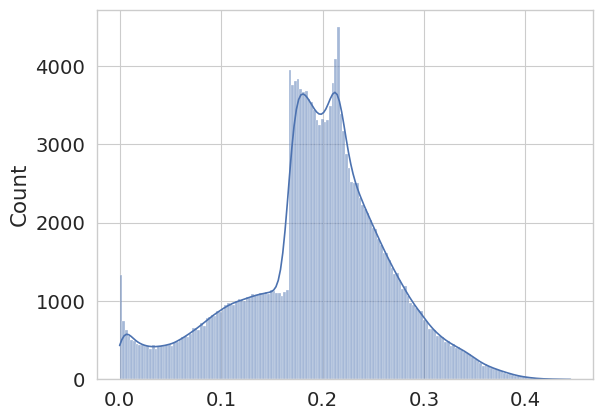

In [40]:

sampling_dataset = 'multilabel_full'
sampling_model = 'LXR111'


base_path = '../../../snap/vqa/lxr111_multilabel_full_run_3/'
df = pd.read_pickle(base_path+"datamap_metrics.pkl")

conf = stratified_beta_multilabel_var_conf(df, sampling_model, 30, dataset=sampling_dataset)

<AxesSubplot:ylabel='Count'>

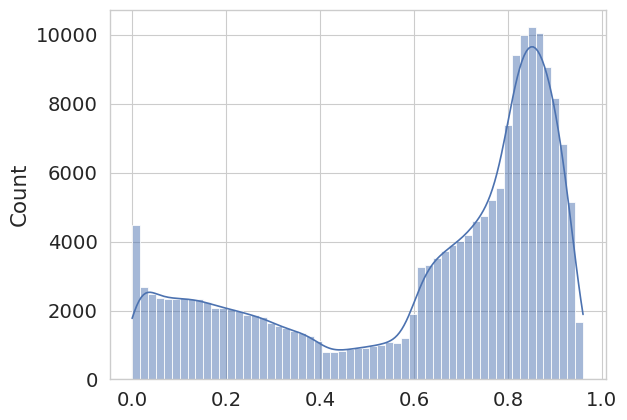

In [41]:
sns.histplot(conf, kde=True)

# While loop to reach the budget - this is wrong


In [16]:
'''
* This is an odd variant of stratified beta sampling and is the same as vanilla
    stratified sampling but is using a while loop to reach the training budget 

* This ends up looking different from the beta distibution that we are going for 
    so its not something we want to stick with 
'''
def stratified_beta_multilabel_budget(df, alpha, beta, model, training_budget, dataset='animals'):
    #df = df.sample(frac=0.5, replace=False, random_state=1)
    targets = df['Target'].tolist()
    targets = [i[0] for i in targets]
    df['Target'] = targets
    orig_df = df.copy()
    all_ids = df['question_id'].to_list()
    total_samples = round((training_budget*0.01) * len(all_ids))

    targets_list = np.array(df['Target'].tolist())
    question_ids = np.array(df['question_id'].to_list())
    #confidence = np.array(df['confidence'].tolist())
    variability = np.array(df['variability'].tolist())


    targets_multilabel =[] # unique targets in vqa dataset 
    for i in targets_list:
        target_list = [x.strip() for x in i.split(',')]
        targets_multilabel.extend(target_list)
    unique_targets = set(targets_multilabel)

    df_variability = pd.DataFrame({'variability':variability, 'question_id':question_ids})
    bins = pd.cut(variability, bins=np.linspace(0, 0.5, 6), right=True, retbins=True)
    df_variability['bins'] = bins[0]
    
    beta_distribution = scipy.stats.beta(alpha, beta)
    sampling_percentages = [beta_distribution.cdf(0.2), beta_distribution.cdf(0.4)-beta_distribution.cdf(0.2), beta_distribution.cdf(0.6)-beta_distribution.cdf(0.4), beta_distribution.cdf(0.8)-beta_distribution.cdf(0.6), beta_distribution.cdf(1) - beta_distribution.cdf(0.8)]
    #sampling_percentages = [beta_distribution.cdf(0.25), beta_distribution.cdf(0.5)-beta_distribution.cdf(0.25), beta_distribution.cdf(0.75)-beta_distribution.cdf(0.5), beta_distribution.cdf(1)-beta_distribution.cdf(0.75)]
    unique_bins = df_variability['bins'].unique().tolist()
    print(unique_bins)

    first_bin = df_variability.loc[df_variability['bins'] == unique_bins[2]]
    second_bin = df_variability.loc[df_variability['bins'] == unique_bins[0]]
    third_bin = df_variability.loc[df_variability['bins'] == unique_bins[1]]
    fourth_bin = df_variability.loc[df_variability['bins'] == unique_bins[3]]
    fifth_bin = df_variability.loc[df_variability['bins'] == unique_bins[4]]

    all_bins = [first_bin, second_bin, third_bin, fourth_bin, fifth_bin]
    final_sample = []
    final_sample_ids = []

    while len(final_sample_ids) < total_samples:
        for idx, sampling_percentage in enumerate(sampling_percentages):
            sampled_points = all_bins[idx].sample(frac=sampling_percentage, replace=False)
            if len(sampled_points) + len(final_sample) > total_samples:
                cropped = total_samples - len(final_sample)
                sampled_points = sampled_points.iloc[:cropped]
                all_bins[idx] = all_bins[idx][~all_bins[idx]['question_id'].isin(sampled_points['question_id'].tolist())]
                final_sample.extend(sampled_points['variability'].tolist())
                final_sample_ids.extend(sampled_points['question_id'].tolist())
            else:
                all_bins[idx] = all_bins[idx][~all_bins[idx]['question_id'].isin(sampled_points['question_id'].tolist())]
                final_sample.extend(sampled_points['variability'].tolist())
                final_sample_ids.extend(sampled_points['question_id'].tolist())

    sns.histplot(final_sample, kde=True)
    total_samples = round((training_budget*0.01) * len(all_ids))
    print("Total samples: ", total_samples)
    print("sample size: ", len(set(final_sample)))


    save_path = '../../../src/dataset_selection/sampling/samples/'+model+'/'+dataset+'/beta/var_stratified/seed_'+str(965)+'/alpha_'+str(alpha)+'_beta_'+str(beta)+'_budget_'+str(training_budget)+'budget.pkl'
    with open(save_path, 'wb') as f:
        pickle.dump(list(set(final_sample_ids)), f)

    unique_targets_sample = orig_df[orig_df['question_id'].isin(final_sample_ids)]
    sampled_targets_unique =[] # unique targets in vqa dataset 
    targets_list_sampled = np.array(unique_targets_sample['Target'].tolist())
    for i in targets_list_sampled:
        target_list = [x.strip() for x in i.split(',')]
        sampled_targets_unique.extend(target_list)
    unique_targets_sampled = set(sampled_targets_unique)

    # sampled_targets_unique = [] # unique targets in sampled data
    # sampled_targets = set(unique_targets_sample['Target'].unique())
    # for sample in sampled_targets:
    #     target_list = [x.strip() for x in sample.split(',')]
    #     sampled_targets_unique.extend(target_list)
    # sampled_targets_unique = set(sampled_targets_unique)
    targets_excluded = unique_targets - unique_targets_sampled
    print("TARGETS excluded: ", len(targets_excluded))

    print("unique targets max variability per class: ", len(set(unique_targets_sampled)))
    print('samples - max variability per class: ', len(set(final_sample)))
    print('all_samples - max variability per class: ', len(all_ids))

[Interval(0.1, 0.2, closed='right'), Interval(0.2, 0.3, closed='right'), Interval(0.0, 0.1, closed='right'), Interval(0.3, 0.4, closed='right'), Interval(0.4, 0.5, closed='right')]
Total samples:  185817
sample size:  185817
TARGETS excluded:  1
unique targets max variability per class:  3127
samples - max variability per class:  185817
all_samples - max variability per class:  619390


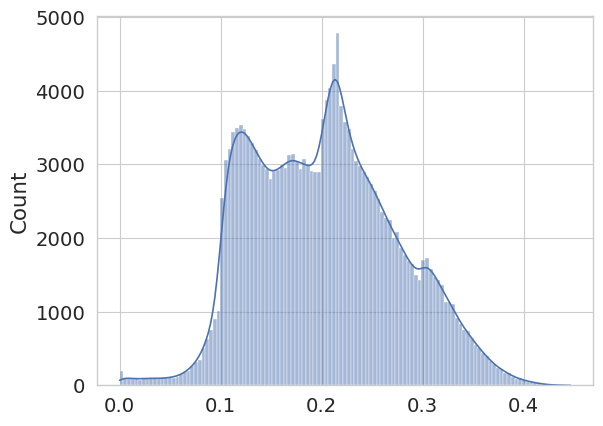

In [17]:

sampling_dataset = 'multilabel_full'
sampling_model = 'LXR111'


base_path = '../../../snap/vqa/lxr111_multilabel_full_run_3/'
df = pd.read_pickle(base_path+"datamap_metrics.pkl")

stratified_beta_multilabel_budget(df, 2, 1, sampling_model, 30, dataset=sampling_dataset)